In [ ]:
#Что сделано:
1. Кастомный датасет для масок+картинок
2. Аугментация
3. Собственная реализация DeconvNet для семантической сегментации
4. Обучение, визуализация результатов, подсчет качества по метрике mIoU
5. Обучение готовой UNet c backbone mobilenet_v2, визуализация результатов, подсчет mIoU


In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
import torchvision
import torch.nn.functional as F
from torch.autograd import Variable

from PIL import Image
import cv2
import albumentations as A
import seaborn as sns
import time
import os
from tqdm.notebook import tqdm

!pip install -q segmentation-models-pytorch
!pip install -q torchsummary

from torchsummary import summary
import segmentation_models_pytorch as smp

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from fastai.data.external import *

In [ ]:
#Имеется датасет картинок с их масками (маски цветные, не закодированы в формат [0;n-1 число классов])

In [2]:
#converters чтобы не пропадали нули перед цифрами при загрузке датасета (т.е. чтобы 0000047 не превращалось в 47)
csv = pd.read_csv("../input/stanford-background-dataset/metadata.csv", converters={'image_id': str})
csv = csv["image_id"]
csv.head(10)

0    0000047
1    0000051
2    0000059
3    0000072
4    0000087
5    0000176
6    0000382
7    0000631
8    0000643
9    0000697
Name: image_id, dtype: object

In [3]:
#Сделаем csv файл для train, val, test
csv_trainval, csv_test = train_test_split(csv, test_size = 0.10, random_state = 42, shuffle = True)
csv_trainval = csv_trainval.reset_index(drop = True)
csv_test = csv_test.reset_index(drop = True)
csv_train, csv_val = train_test_split(csv_trainval, test_size = 0.10, random_state = 42, shuffle = True)
csv_train = csv_train.reset_index(drop = True)
csv_val = csv_val.reset_index(drop = True)


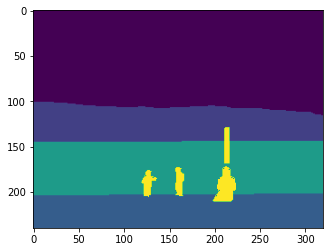

In [4]:
#посмотрим на одну из масок 
img = cv2.imread("../input/stanford-background-dataset/labels_colored/0000051.png", cv2.IMREAD_GRAYSCALE)
img = Image.fromarray(img)
plt.imshow(img)

In [5]:
#Пишем кастомный датасет. В нем достаем картинку и ее маску. В маске рандомные значения (30, 60, 77 и т.д.), а надо [0; 8] т.к. 8 классов.
#Здесь заменим эти значения вручную, хотя в дальнейшем лучше найти автоматический способ. Важно, маска должна быть в формате .long()
class CustomDataset(Dataset):
    def __init__(self, img_path, mask_path, csv, mean, std, transform = None):
        self.img_path = img_path
        self.mask_path = mask_path
        self.csv = csv
        self.transform = transform
        self.mean = mean
        self.std = std
        
    def __len__(self):
        return len(self.csv)
    
    def __getitem__(self, idx):
        path = os.path.join(self.img_path, csv[idx]) + ".jpg"
        img = cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask_path = os.path.join(self.mask_path, csv[idx]) + ".png"
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask[mask == 30] = 0
        mask[mask == 60] = 1
        mask[mask == 77] = 2
        mask[mask == 91] = 3
        mask[mask == 137] = 4
        mask[mask == 189] = 5
        mask[mask == 117] = 6
        mask[mask == 163] = 7
        mask[mask == 103] = 8
        
        if self.transform is not None:
            aug = self.transform(image=img, mask=mask)
            img = Image.fromarray(aug['image'])
            mask = aug['mask']
        
        if self.transform is None:
            img = Image.fromarray(img)
        
        t = T.Compose([T.ToTensor(), T.Normalize(self.mean, self.std)])
        img = t(img)
        mask = torch.from_numpy(mask).long()
        
            
        return img, mask
        

In [6]:
#Проверим какая в среднем ширина и высота. Было принято решение брать 240х240
check_width = pd.read_csv("../input/stanford-background-dataset/metadata.csv")
check_width = check_width.iloc[:, [1,2]]
check_width.describe()

,image_width,image_height
count,715.000000,715.000000
mean,314.469930,241.240559
std,21.600462,24.669712
min,213.000000,137.000000
25%,320.000000,240.000000
50%,320.000000,240.000000
75%,320.000000,240.000000
max,320.000000,320.000000


In [7]:
img = cv2.imread("../input/stanford-background-dataset/images/0000047.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = torch.from_numpy(img)
img.shape

torch.Size([240, 320, 3])

In [15]:
#Пишем аугментацию и строим наши датасеты и даталоадеры
#Тут resize (240,240) для собственной, (256,256) для unet
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]
img_path = "../input/stanford-background-dataset/images"
mask_path = "../input/stanford-background-dataset/labels_colored"


t_train = A.Compose([A.Resize(256, 256), A.HorizontalFlip(p = 0.2), A.VerticalFlip(p=0.2), 
                     A.GridDistortion(p=0.2), A.RandomBrightnessContrast((0,0.5),(0,0.5)),
                     A.GaussNoise()])

t_val = A.Compose([A.Resize(256, 256)])

#datasets
train_set = CustomDataset(img_path, mask_path, csv_train, mean, std, t_train)
val_set = CustomDataset(img_path, mask_path, csv_val, mean, std, t_val)

#dataloader
batch_size= 10

trainloader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
valloader = DataLoader(val_set, batch_size=batch_size, shuffle=True)               

In [10]:
#Здесь проверяли уникальные значения (как раз чтобы вручную заменить их на [0;8] в CustomDataset)
torch.unique(train_set[13][1])

tensor([0, 1, 3, 4, 5, 8])

In [7]:
#Проверяем что аугментация применилась и shape = 240x240
train_set[6][0].shape

torch.Size([3, 240, 240])

In [8]:
#Common deconv net - encoder с maxpooling'ами, уменьшающими размерность каждый раз в 2 раза, а затем deconv - transpose 
#возвращающий размерность обратно   P.S. в будущем пишем такое заранее созданными блоками (пока же просто для понимания пишем полностью каждый слой)
class DeconvNet(nn.Module):
    def __init__(self):
        super(DeconvNet, self).__init__()
        #pooling
        self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 42, kernel_size = 3, stride = 1, padding = 1)
        self.bn1 = nn.BatchNorm2d(42)
        self.conv2 = nn.Conv2d(in_channels = 42, out_channels = 42, kernel_size = 5, stride = 1, padding = 2)
        self.bn2 = nn.BatchNorm2d(42)
        self.pool1 = nn.MaxPool2d(kernel_size=4, stride=2)
        
        self.conv3 = nn.Conv2d(in_channels=42, out_channels=100, kernel_size=5, stride = 1, padding = 2)
        self.bn3 = nn.BatchNorm2d(100)
        self.conv4 = nn.Conv2d(in_channels=100, out_channels=100, kernel_size=9, stride = 1, padding = 4)
        self.bn4 = nn.BatchNorm2d(100)
        self.pool2 = nn.MaxPool2d(kernel_size=4, stride=2)
        
        self.conv5 = nn.Conv2d(in_channels=100, out_channels=150, kernel_size=5, stride = 1, padding = 2)
        self.bn5 = nn.BatchNorm2d(150)
        self.conv6 = nn.Conv2d(in_channels=150, out_channels=150, kernel_size=9, stride = 1, padding = 4)
        self.bn6 = nn.BatchNorm2d(150)
        self.conv7 = nn.Conv2d(in_channels=150, out_channels=150, kernel_size=9, stride = 1, padding = 4)
        self.bn7 = nn.BatchNorm2d(150)
        self.pool3 = nn.MaxPool2d(kernel_size=4, stride=2)
        
        self.conv8 = nn.Conv2d(in_channels=150, out_channels=220, kernel_size=3, stride = 1, padding = 1)
        self.bn8 = nn.BatchNorm2d(220)
        self.conv9 = nn.Conv2d(in_channels=220, out_channels=220, kernel_size=5, stride = 1, padding = 2)
        self.bn9 = nn.BatchNorm2d(220)
        self.conv10 = nn.Conv2d(in_channels=220, out_channels=220, kernel_size=9, stride = 1, padding = 4)
        self.bn10 = nn.BatchNorm2d(220)
        self.pool4 = nn.MaxPool2d(kernel_size=4, stride=2)
        
        self.conv11 = nn.Conv2d(in_channels=220, out_channels=400, kernel_size=3, stride = 1, padding = 1)
        self.bn11 = nn.BatchNorm2d(400)
        self.conv12 = nn.Conv2d(in_channels=400, out_channels=400, kernel_size=5, stride = 1, padding = 2)
        self.bn12 = nn.BatchNorm2d(400)
        self.conv13 = nn.Conv2d(in_channels=400, out_channels=400, kernel_size=9, stride = 1, padding = 4)
        self.bn13 = nn.BatchNorm2d(400)
        self.pool5 = nn.MaxPool2d(kernel_size=4, stride=2)
        
        self.conv14 = nn.Conv2d(in_channels=400, out_channels=450, kernel_size=5, stride = 1, padding = 2)
        self.bn14 = nn.BatchNorm2d(450)
        self.conv15 = nn.Conv2d(in_channels=450, out_channels=450, kernel_size=5, stride = 1, padding = 2)
        self.bn15 = nn.BatchNorm2d(450)
        
        #unpooling
        self.tr_conv1 = nn.ConvTranspose2d(in_channels = 450, out_channels = 350, kernel_size = 5, stride = 2)
        self.conv16 = nn.Conv2d(in_channels=350, out_channels=350, kernel_size=3, stride = 1, padding = 1)
        self.bn16 = nn.BatchNorm2d(350)
        self.conv17 = nn.Conv2d(in_channels=350, out_channels=350, kernel_size=5, stride = 1, padding = 2)
        self.bn17 = nn.BatchNorm2d(350)
        self.conv18 = nn.Conv2d(in_channels=350, out_channels=350, kernel_size=9, stride = 1, padding = 4)
        self.bn18 = nn.BatchNorm2d(350)
        
        self.tr_conv2 = nn.ConvTranspose2d(in_channels = 350, out_channels = 220, kernel_size = 4, stride = 2)
        self.conv19 = nn.Conv2d(in_channels=220, out_channels=220, kernel_size=3, stride = 1, padding = 1)
        self.bn19 = nn.BatchNorm2d(220)
        self.conv20 = nn.Conv2d(in_channels=220, out_channels=220, kernel_size=5, stride = 1, padding = 2)
        self.bn20 = nn.BatchNorm2d(220)
        self.conv21 = nn.Conv2d(in_channels=220, out_channels=220, kernel_size=9, stride = 1, padding = 4)
        self.bn21 = nn.BatchNorm2d(220)
        
        self.tr_conv3 = nn.ConvTranspose2d(in_channels = 220, out_channels = 150, kernel_size = 4, stride = 2)
        self.conv22 = nn.Conv2d(in_channels=150, out_channels=150, kernel_size=3, stride = 1, padding = 1)
        self.bn22 = nn.BatchNorm2d(150)
        self.conv23 = nn.Conv2d(in_channels=150, out_channels=150, kernel_size=5, stride = 1, padding = 2)
        self.bn23 = nn.BatchNorm2d(150)
        self.conv24 = nn.Conv2d(in_channels=150, out_channels=150, kernel_size=9, stride = 1, padding = 4)
        self.bn24 = nn.BatchNorm2d(150)
        
        self.tr_conv4 = nn.ConvTranspose2d(in_channels = 150, out_channels = 100, kernel_size = 5, stride = 2)
        self.conv25 = nn.Conv2d(in_channels=100, out_channels=100, kernel_size=3, stride = 1, padding = 1)
        self.bn25 = nn.BatchNorm2d(100)
        self.conv26 = nn.Conv2d(in_channels=100, out_channels=100, kernel_size=5, stride = 1, padding = 2)
        self.bn26 = nn.BatchNorm2d(100)
        
        self.tr_conv5 = nn.ConvTranspose2d(in_channels = 100, out_channels = 42, kernel_size = 4, stride = 2)
        self.conv27 = nn.Conv2d(in_channels=42, out_channels=42, kernel_size=3, stride = 1, padding = 1)
        self.bn27 = nn.BatchNorm2d(42)
        self.conv28 = nn.Conv2d(in_channels=42, out_channels=9, kernel_size=5, stride = 1, padding = 2)
        
        self.relu = nn.ReLU()
        
        
        
        
    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.pool1(self.relu(self.bn2(self.conv2(x))))
        x = self.relu(self.bn3(self.conv3(x)))
        x = self.pool2(self.relu(self.bn4(self.conv4(x))))
        x = self.relu(self.bn5(self.conv5(x)))
        x = self.relu(self.bn6(self.conv6(x)))
        x = self.pool3(self.relu(self.bn7(self.conv7(x))))
        x = self.relu(self.bn8(self.conv8(x)))
        x = self.relu(self.bn9(self.conv9(x)))
        x = self.pool4(self.relu(self.bn10(self.conv10(x))))
        x = self.relu(self.bn11(self.conv11(x)))
        x = self.relu(self.bn12(self.conv12(x)))
        x = self.pool5(self.relu(self.bn13(self.conv13(x))))
        x = self.relu(self.bn14(self.conv14(x)))
        x = self.relu(self.bn15(self.conv15(x)))
        
        x = self.relu(self.tr_conv1(x))
        x = self.relu(self.bn16(self.conv16(x)))
        x = self.relu(self.bn17(self.conv17(x)))
        x = self.relu(self.bn18(self.conv18(x)))
        x = self.relu(self.tr_conv2(x))
        x = self.relu(self.bn19(self.conv19(x)))
        x = self.relu(self.bn20(self.conv20(x)))
        x = self.relu(self.bn21(self.conv21(x)))
        x = self.relu(self.tr_conv3(x))
        x = self.relu(self.bn22(self.conv22(x)))
        x = self.relu(self.bn23(self.conv23(x)))
        x = self.relu(self.bn24(self.conv24(x)))
        x = self.relu(self.tr_conv4(x))
        x = self.relu(self.bn25(self.conv25(x)))
        x = self.relu(self.bn26(self.conv26(x)))
        x = self.relu(self.tr_conv5(x))
        x = self.relu(self.bn27(self.conv27(x)))
        x = self.conv28(x)
        
        return x

In [46]:
#Просто проверка выхода, выход сети должен быть [батч сайз;число каналов(классов); ширина;высота]
model = DeconvNet()
model(train_set[0][0].view(1, 3, 240, 240)).shape

torch.Size([1, 9, 240, 240])

In [9]:
#Функции для подсчета score'ов. На train loop'e работают не аддекватно, т.к. надо разобраться, нужно ли делить на processed_size
def pixel_accuracy(output, mask):
    with torch.no_grad():
        output = torch.argmax(F.softmax(output, dim=1), dim=1)
        correct = torch.eq(output, mask).int()
        accuracy = float(correct.sum()) / float(correct.numel())
    return accuracy

def mIoU(pred_mask, mask, smooth=1e-10, n_classes=9):
    with torch.no_grad():
        pred_mask = F.softmax(pred_mask, dim=1)
        pred_mask = torch.argmax(pred_mask, dim=1)
        pred_mask = pred_mask.contiguous().view(-1)
        mask = mask.contiguous().view(-1)

        iou_per_class = []
        for clas in range(0, n_classes): #loop per pixel class
            true_class = pred_mask == clas
            true_label = mask == clas

            if true_label.long().sum().item() == 0: #no exist label in this loop
                iou_per_class.append(np.nan)
            else:
                intersect = torch.logical_and(true_class, true_label).sum().float().item()
                union = torch.logical_or(true_class, true_label).sum().float().item()

                iou = (intersect + smooth) / (union +smooth)
                iou_per_class.append(iou)
        return np.nanmean(iou_per_class)

In [13]:
#Обучаем
model = DeconvNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=3e-5)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.8)
num_epochs = 260

best_model_wts = model.state_dict()
best_acc = 0.0
    

losses = {'train': [], "val": []}

# Run the training loop for defined number of epochs
for epoch in range(num_epochs):
    running_loss = 0
    processed_data = 0
    processed_size1 = 0
    running_loss1 = 0
    running_corrects = 0
    val_iou_score = 0
    test_accuracy = 0
    for batch_i, (data, target) in tqdm(enumerate(trainloader), total = len(trainloader)):
        data, target = data.to(device), target.to(device)
        model.train()
        optimizer.zero_grad()
        y_pred = model(data)
        loss = criterion(y_pred, target)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * data.size(0)
        processed_data += data.size(0)
    train_loss = running_loss / processed_data
    model.eval()
    with torch.no_grad():
        for data, target in tqdm(valloader):
            data, target = data.to(device), target.to(device)
            probs = model(data)
            lossfc = criterion(probs, target) 
            running_loss1 += lossfc.item() * data.size(0)
            processed_size1 += data.size(0)
            val_iou_score +=  mIoU(probs, target)
            test_accuracy += pixel_accuracy(probs, target)
        
            
        val_loss = running_loss1 / processed_size1 
        val_acc = test_accuracy / processed_size1
        val_iou = val_iou_score / processed_size1
        
        losses["train"].append(train_loss)
        losses["val"].append(val_loss)
        
        if val_acc > best_acc:
                best_acc = val_acc
                best_model_wts = model.state_dict()
    print("Epoch" + " " + str(epoch) + ":", "train_loss:" + str(train_loss), "val_loss:" + str(val_loss), "val_acc:" + str(val_acc), "val_IoU:" + str(val_iou))
    scheduler.step()

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 0: train_loss:2.0176911077697386 val_loss:1.8657942001636212 val_acc:0.04269131944444445 val_IoU:0.014328589156419455


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 1: train_loss:1.729727045474993 val_loss:1.7193405719903798 val_acc:0.045757745726495734 val_IoU:0.01591428301215084


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 2: train_loss:1.6544862412251402 val_loss:1.6194511010096624 val_acc:0.05070435363247863 val_IoU:0.019645120342746968


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 3: train_loss:1.5966372857044313 val_loss:1.5801954452808087 val_acc:0.04923800747863249 val_IoU:0.019506122984616625


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 4: train_loss:1.5361834846978368 val_loss:1.5255278807419996 val_acc:0.05090956196581197 val_IoU:0.02141415586008828


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 5: train_loss:1.5330264964318192 val_loss:1.5651655288843007 val_acc:0.04771784188034188 val_IoU:0.019313692960078458


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 6: train_loss:1.5001907488879036 val_loss:1.511866413629972 val_acc:0.05090921474358975 val_IoU:0.021402373595749966


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 7: train_loss:1.4720551579881291 val_loss:1.6209644812804003 val_acc:0.04724196047008546 val_IoU:0.0211332398394378


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 8: train_loss:1.4490171662663918 val_loss:1.4799042206544142 val_acc:0.053876442307692306 val_IoU:0.023664128335292238


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 9: train_loss:1.4426196516591372 val_loss:1.508527003801786 val_acc:0.05020045405982905 val_IoU:0.022492039914871968


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 10: train_loss:1.4415135606349958 val_loss:1.6269490168644831 val_acc:0.04288432158119658 val_IoU:0.01766684475886275


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 11: train_loss:1.4020734006558322 val_loss:1.5265421683971698 val_acc:0.049133760683760686 val_IoU:0.021376487328417865


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 12: train_loss:1.4117658521889815 val_loss:1.4260289210539598 val_acc:0.05442248931623932 val_IoU:0.02267091206102831


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 13: train_loss:1.3924834629243632 val_loss:1.4863714713316698 val_acc:0.05402021901709402 val_IoU:0.02428599975555198


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 14: train_loss:1.35168093216048 val_loss:1.5953620488827045 val_acc:0.049329407051282054 val_IoU:0.019939401925144536


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 15: train_loss:1.3226746786836934 val_loss:1.4097827856357281 val_acc:0.05296709401709402 val_IoU:0.02258344891971187


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 16: train_loss:1.3191641185522904 val_loss:1.4047993696652925 val_acc:0.05642847222222222 val_IoU:0.025464656160864643


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 17: train_loss:1.3206760454342852 val_loss:1.3481058524205134 val_acc:0.05643800747863247 val_IoU:0.025006736950374406


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 18: train_loss:1.2960082465802096 val_loss:1.3623031102693999 val_acc:0.05582323717948717 val_IoU:0.02410649279104922


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 19: train_loss:1.2696386008526628 val_loss:1.4315534921792836 val_acc:0.05549826388888889 val_IoU:0.025170346003906587


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 20: train_loss:1.2425572824725644 val_loss:1.3056302987612212 val_acc:0.05792930021367521 val_IoU:0.0276510962547314


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 21: train_loss:1.237317914575029 val_loss:1.2852442723054152 val_acc:0.05972120726495727 val_IoU:0.02932284549426048


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 22: train_loss:1.2054920646146094 val_loss:1.2613418744160578 val_acc:0.059969631410256415 val_IoU:0.028871848322278317


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 23: train_loss:1.1862918427246252 val_loss:1.2669440507888794 val_acc:0.05910814636752137 val_IoU:0.027278442107971552


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 24: train_loss:1.2048633680211631 val_loss:1.3685362430719228 val_acc:0.05654415064102564 val_IoU:0.024382290685495498


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 25: train_loss:1.1911849294979266 val_loss:1.2347747821074266 val_acc:0.05948944978632478 val_IoU:0.028112072842917887


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 26: train_loss:1.1478544325152071 val_loss:1.200813623575064 val_acc:0.06105531517094018 val_IoU:0.02883875818464975


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 27: train_loss:1.1443272697059341 val_loss:1.1714646449455848 val_acc:0.06441581196581196 val_IoU:0.03109490577505887


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 28: train_loss:1.1408992306583894 val_loss:1.1648470071645884 val_acc:0.06427922008547009 val_IoU:0.029997448249580647


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 29: train_loss:1.1229173934995922 val_loss:1.148070032779987 val_acc:0.06438450854700854 val_IoU:0.03273990100796975


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 31: train_loss:1.0962363665079162 val_loss:1.0654443364876967 val_acc:0.07062516025641025 val_IoU:0.037855006260680855


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 32: train_loss:1.058457624541022 val_loss:1.0643084599421575 val_acc:0.06893293269230769 val_IoU:0.035330898410006


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 33: train_loss:1.0530602700982539 val_loss:1.0667650516216571 val_acc:0.07029163995726495 val_IoU:0.03834939422625876


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 34: train_loss:1.0376314675519211 val_loss:1.079237965437082 val_acc:0.06708595085470086 val_IoU:0.036484263371282875


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 35: train_loss:1.0636908954402566 val_loss:1.0630288765980647 val_acc:0.06899107905982906 val_IoU:0.03935102575531979


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 36: train_loss:1.0238164333323707 val_loss:1.0415346989264855 val_acc:0.06960165598290599 val_IoU:0.03795191857392676


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 37: train_loss:1.0380738154827105 val_loss:1.0411192866472097 val_acc:0.07042783119658119 val_IoU:0.039953164562651314


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 38: train_loss:1.0097884395543266 val_loss:1.0281624839856074 val_acc:0.07061963141025641 val_IoU:0.039378411458318385


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 39: train_loss:1.0099238580073453 val_loss:1.0103123554816613 val_acc:0.0713874732905983 val_IoU:0.03845622971339242


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 40: train_loss:0.9929826494731705 val_loss:0.9897456169128418 val_acc:0.07088512286324787 val_IoU:0.041925842099419165


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 41: train_loss:1.0125770925650548 val_loss:0.9655537742834824 val_acc:0.07272377136752137 val_IoU:0.041678731418745694


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 42: train_loss:1.0019328443649318 val_loss:1.0299871151263897 val_acc:0.07039545940170941 val_IoU:0.037155605124540546


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 43: train_loss:1.018760738694544 val_loss:0.9733931238834674 val_acc:0.07424188034188034 val_IoU:0.041774048052917005


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 44: train_loss:0.9924221294561472 val_loss:0.9568110154225276 val_acc:0.07352406517094016 val_IoU:0.04227137997759804


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 45: train_loss:0.9500139852708599 val_loss:0.9367543917435867 val_acc:0.07364313568376069 val_IoU:0.04218449898704368


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 46: train_loss:0.935022267297065 val_loss:0.894292258299314 val_acc:0.07493557692307692 val_IoU:0.04522628484135138


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 47: train_loss:0.9335118086692784 val_loss:0.8992750002787664 val_acc:0.07569436431623931 val_IoU:0.04355719143977246


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 48: train_loss:0.9387627456427445 val_loss:0.913671062542842 val_acc:0.07422422542735042 val_IoU:0.04266508025206777


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 49: train_loss:0.936673279245832 val_loss:0.8853376278510461 val_acc:0.07548066239316241 val_IoU:0.045418445238369944


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 50: train_loss:0.9287613634419689 val_loss:0.8810259241324204 val_acc:0.0767235844017094 val_IoU:0.04668399554839058


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 51: train_loss:0.9308008312354038 val_loss:0.8798889380234939 val_acc:0.07641789529914529 val_IoU:0.04505694582651767


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 52: train_loss:0.9268421208982237 val_loss:0.9098341373296884 val_acc:0.07364193376068376 val_IoU:0.04339188135672451


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 53: train_loss:0.9219024364923524 val_loss:0.8654476633438697 val_acc:0.07768512286324786 val_IoU:0.047489022013208926


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 54: train_loss:0.8968990834939026 val_loss:0.9254336265417246 val_acc:0.07272940705128204 val_IoU:0.03941854936813516


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 55: train_loss:0.8930039989494535 val_loss:0.8316392164963943 val_acc:0.07643186431623931 val_IoU:0.044054394802644344


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 56: train_loss:0.8764550989061903 val_loss:0.8322303570233859 val_acc:0.0768880876068376 val_IoU:0.047598902338580155


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 57: train_loss:0.8631780524979825 val_loss:0.7970157999258775 val_acc:0.07883290598290599 val_IoU:0.047947568851584396


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 58: train_loss:0.8856182100451117 val_loss:0.8163184110934918 val_acc:0.07840980235042735 val_IoU:0.04660954988201952


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 59: train_loss:0.8699382093950951 val_loss:0.8280168955142682 val_acc:0.07714209401709402 val_IoU:0.04489725189351869


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 60: train_loss:0.8771486894894637 val_loss:0.790230210010822 val_acc:0.07821778846153846 val_IoU:0.04908018084481138


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 61: train_loss:0.8453062962495744 val_loss:0.7951936217454764 val_acc:0.07904553952991453 val_IoU:0.048652331212698886


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 62: train_loss:0.8618679778798641 val_loss:0.7753322949776282 val_acc:0.07994780982905984 val_IoU:0.04924733731242958


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 63: train_loss:0.8344277104291948 val_loss:0.7736443327023432 val_acc:0.07985267094017094 val_IoU:0.047577277262450056


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 64: train_loss:0.8341647178244014 val_loss:0.782097211250892 val_acc:0.08017935363247863 val_IoU:0.051642680760738816


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 65: train_loss:0.8208240289176624 val_loss:0.7479974214847271 val_acc:0.08016677350427351 val_IoU:0.04857127223302007


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 66: train_loss:0.8048005551615388 val_loss:0.7408138192616976 val_acc:0.08054751602564103 val_IoU:0.04978207963789868


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 67: train_loss:0.7739549132779395 val_loss:0.7205754014161917 val_acc:0.08262264957264957 val_IoU:0.052057188951393406


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 68: train_loss:0.8044646446267626 val_loss:0.7344327569007874 val_acc:0.08096992521367521 val_IoU:0.05042800875245046


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 69: train_loss:0.7919739072298096 val_loss:0.8215848024074848 val_acc:0.0780056891025641 val_IoU:0.046694081595280074


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 70: train_loss:0.8382535531446595 val_loss:0.7632157756732061 val_acc:0.07953330662393163 val_IoU:0.04694464088233872


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 71: train_loss:0.8212415613105141 val_loss:0.7272135202701275 val_acc:0.08146065705128207 val_IoU:0.05102133416727953


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 72: train_loss:0.7913863968271697 val_loss:0.7247787301356976 val_acc:0.08115125534188035 val_IoU:0.05086281400643836


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 73: train_loss:0.7796974827674021 val_loss:0.6938027281027573 val_acc:0.08238936965811966 val_IoU:0.05079719312067215


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 74: train_loss:0.794998253918024 val_loss:0.7013533252936143 val_acc:0.08195325854700855 val_IoU:0.050802522708365466


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 75: train_loss:0.7676419102196875 val_loss:0.669476582453801 val_acc:0.0831831997863248 val_IoU:0.05230970265413342


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 76: train_loss:0.7401478816481197 val_loss:0.6775447497001061 val_acc:0.08261541132478632 val_IoU:0.05132469008539027


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 77: train_loss:0.732752807412593 val_loss:0.6629366599596463 val_acc:0.08421479700854699 val_IoU:0.053707622063878725


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 78: train_loss:0.7311811975129335 val_loss:0.6528797929103558 val_acc:0.08403135683760685 val_IoU:0.054258486174864076


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 79: train_loss:0.7317456002878895 val_loss:0.6690395772457123 val_acc:0.08408608440170941 val_IoU:0.055559918453997624


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 80: train_loss:0.7476488058954787 val_loss:0.6512498167844919 val_acc:0.08386864316239316 val_IoU:0.05327362895311731


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 81: train_loss:0.7568792508960183 val_loss:0.6622515916824341 val_acc:0.08385074786324787 val_IoU:0.05361772725746473


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 82: train_loss:0.7457236505297229 val_loss:0.6418942075509292 val_acc:0.08459981303418804 val_IoU:0.05154313154343704


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 83: train_loss:0.7262513090994944 val_loss:0.632910063633552 val_acc:0.08416164529914531 val_IoU:0.0548529226790358


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 84: train_loss:0.7189693459177512 val_loss:0.6088101176115183 val_acc:0.0852815170940171 val_IoU:0.05457195993334413


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 85: train_loss:0.7194125710061677 val_loss:0.6276216690356915 val_acc:0.08484882478632479 val_IoU:0.05520139042043965


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 86: train_loss:0.7168362406710852 val_loss:0.6172356559680059 val_acc:0.08435189636752137 val_IoU:0.05589496236975687


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 87: train_loss:0.7460571954407081 val_loss:0.6452538462785574 val_acc:0.08432027243589743 val_IoU:0.05511501156047613


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 88: train_loss:0.7205751959015342 val_loss:0.62999905531223 val_acc:0.0844320512820513 val_IoU:0.05434164794033237


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 89: train_loss:0.7031627417023206 val_loss:0.602810236123892 val_acc:0.0850107638888889 val_IoU:0.055862494305090896


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 90: train_loss:0.692846000400794 val_loss:0.5815616754385141 val_acc:0.08631952457264956 val_IoU:0.054951083222539644


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 91: train_loss:0.7015514035538406 val_loss:0.5798555406240317 val_acc:0.08658509615384614 val_IoU:0.058449262733888604


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 92: train_loss:0.6687522696582504 val_loss:0.5612300084187434 val_acc:0.08715713141025641 val_IoU:0.057846987927078666


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 93: train_loss:0.6829728599650637 val_loss:0.5846899793698237 val_acc:0.08691458333333335 val_IoU:0.05620094716617537


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 94: train_loss:0.6816065975539 val_loss:0.5755984645623428 val_acc:0.08641968482905983 val_IoU:0.055709681206189875


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 95: train_loss:0.686074491706274 val_loss:0.5848939006145184 val_acc:0.08645248397435898 val_IoU:0.05524849005624066


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 96: train_loss:0.6765583126602701 val_loss:0.5699023375144372 val_acc:0.08717585470085469 val_IoU:0.05973380019580256


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 97: train_loss:0.6853712097996246 val_loss:0.5794227398358859 val_acc:0.08647916666666666 val_IoU:0.05635775242299438


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 98: train_loss:0.6852206783723667 val_loss:0.5667216319304246 val_acc:0.08716709401709402 val_IoU:0.05954676099576786


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 99: train_loss:0.6794857642642355 val_loss:0.5540395103968107 val_acc:0.08767286324786325 val_IoU:0.0592669566020064


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 100: train_loss:0.6685374586433688 val_loss:0.5498476945436918 val_acc:0.08731177884615385 val_IoU:0.05728218300674769


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 101: train_loss:0.6623831701732424 val_loss:0.5358306352908795 val_acc:0.08814487179487179 val_IoU:0.05614565279913365


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 102: train_loss:0.6548683338099285 val_loss:0.5431948372950921 val_acc:0.0885579861111111 val_IoU:0.06008392666975964


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 103: train_loss:0.6478059225841377 val_loss:0.5386424385584317 val_acc:0.08761204594017093 val_IoU:0.06019890437803544


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 104: train_loss:0.6377672099324658 val_loss:0.5491907779987042 val_acc:0.08769249465811968 val_IoU:0.05825987644725829


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 105: train_loss:0.6370343082297633 val_loss:0.5251595653020419 val_acc:0.0888486111111111 val_IoU:0.05978396402057866


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 106: train_loss:0.6480395977472352 val_loss:0.522709832741664 val_acc:0.08888245192307694 val_IoU:0.061774056027834756


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 107: train_loss:0.6369051160903125 val_loss:0.5262226324815017 val_acc:0.08826680021367521 val_IoU:0.05936384388365785


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 108: train_loss:0.6453665042212265 val_loss:0.5360467365154853 val_acc:0.08836794871794872 val_IoU:0.060871310009870054


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 109: train_loss:0.628900912290626 val_loss:0.5110241724894597 val_acc:0.0894291933760684 val_IoU:0.062251349959544566


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 110: train_loss:0.6222757861069742 val_loss:0.5160177395893977 val_acc:0.08897136752136751 val_IoU:0.059525975037853174


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 111: train_loss:0.6301761971831734 val_loss:0.5220331068222339 val_acc:0.08841607905982905 val_IoU:0.06074779598356956


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 112: train_loss:0.6112473992740407 val_loss:0.5116576002194331 val_acc:0.08946466346153845 val_IoU:0.06115161738735109


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 113: train_loss:0.6172058792675242 val_loss:0.5098632390682514 val_acc:0.0880266826923077 val_IoU:0.060826056825178984


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 114: train_loss:0.6066022883443272 val_loss:0.49589120883208054 val_acc:0.09037013888888888 val_IoU:0.062130552227804885


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 115: train_loss:0.6034729222937851 val_loss:0.48276334083997285 val_acc:0.0913857638888889 val_IoU:0.06218562051140295


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 116: train_loss:0.603776866795695 val_loss:0.4901586885635669 val_acc:0.09016845619658119 val_IoU:0.06358862114814187


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 117: train_loss:0.6190506413733671 val_loss:0.4839206842275766 val_acc:0.09029821047008547 val_IoU:0.062345201554016454


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 118: train_loss:0.6029315319647014 val_loss:0.4849478052212642 val_acc:0.0900451655982906 val_IoU:0.06193975905279423


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 119: train_loss:0.6051339801001301 val_loss:0.48276861814352184 val_acc:0.09032035256410256 val_IoU:0.06249230948423523


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 120: train_loss:0.5929153377003323 val_loss:0.48076839401171756 val_acc:0.09054922542735042 val_IoU:0.06658940261018595


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 121: train_loss:0.5922957835106701 val_loss:0.4688895344734192 val_acc:0.09152198183760685 val_IoU:0.06907017671448124


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 122: train_loss:0.6001877246431001 val_loss:0.475032049875993 val_acc:0.09085902777777778 val_IoU:0.0635745115563161


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 123: train_loss:0.5739342640427982 val_loss:0.4639714451936575 val_acc:0.09136730769230769 val_IoU:0.06576632731391492


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 124: train_loss:0.5805271385450265 val_loss:0.46131969873721784 val_acc:0.09123675213675214 val_IoU:0.06379057019307924


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 125: train_loss:0.5673159814623401 val_loss:0.45484980711570155 val_acc:0.09118090277777778 val_IoU:0.06588958784259398


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 126: train_loss:0.5899489337391507 val_loss:0.45873253162090594 val_acc:0.09114853098290598 val_IoU:0.06473617473134873


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 127: train_loss:0.5918471650268792 val_loss:0.45694756507873535 val_acc:0.09149310897435897 val_IoU:0.0670951838884708


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 128: train_loss:0.5661996773163752 val_loss:0.45327589832819426 val_acc:0.0918036858974359 val_IoU:0.06592330175266925


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 129: train_loss:0.5615860768255478 val_loss:0.44809157802508426 val_acc:0.09161995192307693 val_IoU:0.0651332365087521


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 130: train_loss:0.5898662724090695 val_loss:0.4487618047457475 val_acc:0.09160777243589743 val_IoU:0.06297852562105119


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 131: train_loss:0.5658673369760744 val_loss:0.4556122445143186 val_acc:0.09158538995726496 val_IoU:0.065974935785138


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 132: train_loss:0.5740947025251224 val_loss:0.45026324345515323 val_acc:0.09177863247863248 val_IoU:0.06614994749258778


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 133: train_loss:0.5762220669576453 val_loss:0.44653125221912676 val_acc:0.09156049679487178 val_IoU:0.06463797634716043


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 134: train_loss:0.5770411476956931 val_loss:0.4420938491821289 val_acc:0.09228092948717947 val_IoU:0.06650787915798588


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 135: train_loss:0.5595528051308695 val_loss:0.4351898454702817 val_acc:0.09257686965811965 val_IoU:0.06782742076193632


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 136: train_loss:0.561431633456768 val_loss:0.44091157959057736 val_acc:0.09206097756410257 val_IoU:0.06706362376694802


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 137: train_loss:0.5600219171971186 val_loss:0.4276639956694383 val_acc:0.09273384081196581 val_IoU:0.06739296406997573


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 138: train_loss:0.560677610466637 val_loss:0.43221112398000866 val_acc:0.09228902243589743 val_IoU:0.06756226272564092


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 139: train_loss:0.5609298739260044 val_loss:0.4336520708524264 val_acc:0.09194909188034188 val_IoU:0.06629234337381014


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 140: train_loss:0.5493335971370288 val_loss:0.41698180253689104 val_acc:0.09304650106837607 val_IoU:0.06877339483816035


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 141: train_loss:0.5550710893007298 val_loss:0.42743120514429533 val_acc:0.09259297542735043 val_IoU:0.0670774325698311


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 142: train_loss:0.5515286893580612 val_loss:0.41834794328762936 val_acc:0.09284492521367523 val_IoU:0.06508420104908999


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 143: train_loss:0.5399172470025125 val_loss:0.41959952391110933 val_acc:0.09282719017094017 val_IoU:0.06937271657501756


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 144: train_loss:0.5466364847953756 val_loss:0.41614467134842503 val_acc:0.09281826923076923 val_IoU:0.06912135467207178


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 145: train_loss:0.5474965326926288 val_loss:0.41290942292947036 val_acc:0.09304081196581197 val_IoU:0.06715885188968247


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 146: train_loss:0.5440152907247774 val_loss:0.4160655370125404 val_acc:0.09294155982905981 val_IoU:0.06874185213435059


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 147: train_loss:0.538053353249408 val_loss:0.42784257806264436 val_acc:0.09278645833333334 val_IoU:0.0671183335572662


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 148: train_loss:0.5487729962721828 val_loss:0.4158743711618277 val_acc:0.09306997863247864 val_IoU:0.06901802537765407


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 149: train_loss:0.533085212059912 val_loss:0.4107392384455754 val_acc:0.09292537393162394 val_IoU:0.06722094003819229


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 150: train_loss:0.5361258916582615 val_loss:0.4126068857999948 val_acc:0.09276866987179488 val_IoU:0.06406892173977066


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 151: train_loss:0.528075801150609 val_loss:0.40456658831009495 val_acc:0.09333776709401712 val_IoU:0.07100891198297539


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 152: train_loss:0.5356801665777978 val_loss:0.41033556828132045 val_acc:0.09289500534188035 val_IoU:0.06719784803227928


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 153: train_loss:0.5341248113185064 val_loss:0.40033591252106887 val_acc:0.09353154380341881 val_IoU:0.06930562929498235


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 154: train_loss:0.5318391285965599 val_loss:0.39955477531139666 val_acc:0.09319025106837607 val_IoU:0.06815933686319996


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 155: train_loss:0.5186002115271083 val_loss:0.3959930149408487 val_acc:0.0934258547008547 val_IoU:0.07094087809247948


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 156: train_loss:0.5158985583014967 val_loss:0.40135546830984264 val_acc:0.09322847222222222 val_IoU:0.06901583329443806


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 157: train_loss:0.5465765258226427 val_loss:0.3997836525623615 val_acc:0.09301784188034189 val_IoU:0.06722268424241759


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 158: train_loss:0.5299463901140286 val_loss:0.39492971851275516 val_acc:0.09336917735042734 val_IoU:0.06849332955534011


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 159: train_loss:0.5195224037632398 val_loss:0.38833540907272923 val_acc:0.09345299145299145 val_IoU:0.07082470671648304


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 160: train_loss:0.5205476736733657 val_loss:0.3945048520198235 val_acc:0.09330924145299145 val_IoU:0.06733364326404315


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 161: train_loss:0.5246016603852638 val_loss:0.40113931665053737 val_acc:0.09311239316239317 val_IoU:0.06761964816792419


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 162: train_loss:0.5109898588236641 val_loss:0.39627273495380694 val_acc:0.09332222222222221 val_IoU:0.06668040663740278


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 163: train_loss:0.5122814224871797 val_loss:0.38963353863129246 val_acc:0.0936153579059829 val_IoU:0.06845889422014018


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 164: train_loss:0.5158655355752133 val_loss:0.39348255212490374 val_acc:0.0935829861111111 val_IoU:0.06739371781116534


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 165: train_loss:0.5298395416728353 val_loss:0.38646034781749433 val_acc:0.09366159188034189 val_IoU:0.06954122813744257


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 166: train_loss:0.527941022158494 val_loss:0.38813143510084885 val_acc:0.09380924145299145 val_IoU:0.06918783749194723


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 167: train_loss:0.5068508043214937 val_loss:0.380208609195856 val_acc:0.09391017628205128 val_IoU:0.06967613383591527


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 168: train_loss:0.5008574564357943 val_loss:0.38089320292839635 val_acc:0.0943048344017094 val_IoU:0.07245541452869463


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 169: train_loss:0.5108887631587916 val_loss:0.38041701912879944 val_acc:0.09449273504273503 val_IoU:0.06900509902592149


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 170: train_loss:0.5044591260822586 val_loss:0.38461601504912746 val_acc:0.09404887820512821 val_IoU:0.06936912333680564


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 171: train_loss:0.5001462762949789 val_loss:0.37161662257634676 val_acc:0.09420849358974359 val_IoU:0.06993391571753602


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 172: train_loss:0.5057696876435132 val_loss:0.37354519734015834 val_acc:0.09422230235042735 val_IoU:0.0694077286903075


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 173: train_loss:0.5006801424141987 val_loss:0.37926359130786014 val_acc:0.09383589743589744 val_IoU:0.06844781370299867


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 174: train_loss:0.49120861106265373 val_loss:0.371535083422294 val_acc:0.09432988782051283 val_IoU:0.07147778339627664


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 175: train_loss:0.49528594382081476 val_loss:0.37166390969203067 val_acc:0.09418394764957266 val_IoU:0.07057531343454101


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 176: train_loss:0.49510748256449055 val_loss:0.367431111060656 val_acc:0.09450496794871793 val_IoU:0.07002541591358591


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 177: train_loss:0.5083169878354122 val_loss:0.37076296714636 val_acc:0.09380916132478631 val_IoU:0.06925784164936669


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 178: train_loss:0.4843161091672508 val_loss:0.36763176092734706 val_acc:0.09406386217948717 val_IoU:0.06712731465513999


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 179: train_loss:0.4885368942183194 val_loss:0.36964496970176697 val_acc:0.09435544871794872 val_IoU:0.0714364464032713


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 180: train_loss:0.48343005271106443 val_loss:0.3667872834664125 val_acc:0.09474281517094017 val_IoU:0.06977023829273273


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 181: train_loss:0.49973380132529976 val_loss:0.37400580369509184 val_acc:0.09421388888888889 val_IoU:0.06932056568804726


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 182: train_loss:0.48924214668752414 val_loss:0.3638574710259071 val_acc:0.09432246260683762 val_IoU:0.0696728753091367


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 183: train_loss:0.4958843763105597 val_loss:0.3666681395127223 val_acc:0.09446247329059829 val_IoU:0.07101859079950294


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 184: train_loss:0.4724136443492863 val_loss:0.36254818393633914 val_acc:0.09474180021367522 val_IoU:0.07066228954801548


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 185: train_loss:0.48806267698330863 val_loss:0.3640841864622556 val_acc:0.09409607371794872 val_IoU:0.07142828649648239


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 186: train_loss:0.4925826030000271 val_loss:0.36000580741808963 val_acc:0.09458993055555556 val_IoU:0.06883793749867881


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 187: train_loss:0.48517178870402405 val_loss:0.36244242695661694 val_acc:0.09437489316239317 val_IoU:0.06824764458226973


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 188: train_loss:0.48167665328534004 val_loss:0.3595438507887033 val_acc:0.09478571047008548 val_IoU:0.06978994140707724


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 189: train_loss:0.48789662143350887 val_loss:0.3607705648128803 val_acc:0.094774172008547 val_IoU:0.07166934457921313


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 190: train_loss:0.4868980425451866 val_loss:0.3585892984500298 val_acc:0.09458867521367523 val_IoU:0.07118308379876599


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 191: train_loss:0.4869604917133556 val_loss:0.35925809236673206 val_acc:0.09470040064102565 val_IoU:0.07109979341301187


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 192: train_loss:0.5053247383515315 val_loss:0.36361604928970337 val_acc:0.09449201388888889 val_IoU:0.06963587740916624


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 193: train_loss:0.4880331545346336 val_loss:0.3546945888262529 val_acc:0.09471778846153846 val_IoU:0.07213760594449936


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 194: train_loss:0.4877553177952354 val_loss:0.3607356319060692 val_acc:0.09484126602564102 val_IoU:0.07106391525993434


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 195: train_loss:0.48646344156826243 val_loss:0.354777434697518 val_acc:0.09507179487179486 val_IoU:0.07210855883674692


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 196: train_loss:0.47786347934119017 val_loss:0.35626972867892337 val_acc:0.09500766559829059 val_IoU:0.07114756824237711


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 197: train_loss:0.4687942057126121 val_loss:0.35193628760484547 val_acc:0.09517630876068375 val_IoU:0.07210455347393804


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 198: train_loss:0.47915394165936637 val_loss:0.3508503414117373 val_acc:0.09489569978632478 val_IoU:0.07264949294805222


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 199: train_loss:0.4678933476081769 val_loss:0.34718567591447097 val_acc:0.09494075854700855 val_IoU:0.07129988995388073


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 200: train_loss:0.4694654263014612 val_loss:0.350767236489516 val_acc:0.09500128205128205 val_IoU:0.07425789936865078


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 201: train_loss:0.4739187724862544 val_loss:0.34821950701566845 val_acc:0.09505333867521368 val_IoU:0.06958925042832799


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 202: train_loss:0.4770985160113206 val_loss:0.35486412277588475 val_acc:0.0945315170940171 val_IoU:0.06897127318167892


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 203: train_loss:0.48387799595054043 val_loss:0.3497240268267118 val_acc:0.09508902243589744 val_IoU:0.07182081709133396


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 204: train_loss:0.4655755617008077 val_loss:0.34669316044220555 val_acc:0.09531543803418804 val_IoU:0.07255003804410697


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 205: train_loss:0.4709686063565185 val_loss:0.3477218380341163 val_acc:0.09523336004273504 val_IoU:0.07135411885683945


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 206: train_loss:0.48415044537877544 val_loss:0.34776459061182463 val_acc:0.09474249465811967 val_IoU:0.07032769362722482


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 207: train_loss:0.4705066539630758 val_loss:0.3475041366540469 val_acc:0.09514196047008547 val_IoU:0.07108516745927759


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 208: train_loss:0.47633449202177847 val_loss:0.34455894277645993 val_acc:0.09550261752136753 val_IoU:0.07261189017246454


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 209: train_loss:0.47005489221081187 val_loss:0.3431064761601962 val_acc:0.09528376068376068 val_IoU:0.0710671329754738


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 210: train_loss:0.48082488775253296 val_loss:0.3396662771701813 val_acc:0.09523488247863246 val_IoU:0.07103491800795153


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 211: train_loss:0.46323011655708496 val_loss:0.33790964117416966 val_acc:0.09556599893162392 val_IoU:0.07349366256215696


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 212: train_loss:0.47479629743470453 val_loss:0.34506478905677795 val_acc:0.09529417735042736 val_IoU:0.07344743877335011


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 213: train_loss:0.4621810322195601 val_loss:0.3429785623000218 val_acc:0.09511888354700855 val_IoU:0.07001620859610025


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 214: train_loss:0.4803192813503701 val_loss:0.3383038640022278 val_acc:0.09574863782051282 val_IoU:0.07215199305684837


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 215: train_loss:0.4707524775427518 val_loss:0.3388176216528966 val_acc:0.09550528846153847 val_IoU:0.07414516670269151


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 216: train_loss:0.47072470074706424 val_loss:0.33788910049658555 val_acc:0.09566551816239316 val_IoU:0.07040144494255025


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 217: train_loss:0.47224732243478507 val_loss:0.33696611110980695 val_acc:0.09536554487179487 val_IoU:0.07314914996514559


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 218: train_loss:0.46960091910560237 val_loss:0.3397977077043973 val_acc:0.09546567841880342 val_IoU:0.07128647070459405


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 219: train_loss:0.47162978232525626 val_loss:0.3367869464250711 val_acc:0.09549375 val_IoU:0.07144552960498135


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 220: train_loss:0.4667354226112366 val_loss:0.3405601554192029 val_acc:0.0956071314102564 val_IoU:0.07356047907404868


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 221: train_loss:0.46587756729868457 val_loss:0.3350489162481748 val_acc:0.09528090277777779 val_IoU:0.07060187239112044


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 222: train_loss:0.46157728780099677 val_loss:0.33576653553889346 val_acc:0.09534861111111109 val_IoU:0.07367687446155767


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 223: train_loss:0.45282388383129474 val_loss:0.33545907873373765 val_acc:0.09550261752136753 val_IoU:0.07188891920673893


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 224: train_loss:0.45637594168573925 val_loss:0.3333115875720978 val_acc:0.09581896367521366 val_IoU:0.0756362427397029


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 225: train_loss:0.4655247727686146 val_loss:0.3333599819586827 val_acc:0.09551065705128206 val_IoU:0.0731182515277171


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 226: train_loss:0.4555026151523458 val_loss:0.33692999528004575 val_acc:0.0955611378205128 val_IoU:0.0728486395070894


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 227: train_loss:0.46861407397940086 val_loss:0.3360849962784694 val_acc:0.0956801282051282 val_IoU:0.07355603496602672


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 228: train_loss:0.4656003725982455 val_loss:0.33561015129089355 val_acc:0.0952840811965812 val_IoU:0.07336679624322329


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 229: train_loss:0.4595033914160151 val_loss:0.3335621654987335 val_acc:0.09572192841880342 val_IoU:0.07254987374439019


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 230: train_loss:0.47200276076174935 val_loss:0.3320683057491596 val_acc:0.09569754273504275 val_IoU:0.07308178989616551


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 231: train_loss:0.46688286490918857 val_loss:0.335016505076335 val_acc:0.09541693376068376 val_IoU:0.07111399601513856


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 232: train_loss:0.4573076610746681 val_loss:0.33319953083992004 val_acc:0.09584847756410257 val_IoU:0.07324853710784954


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 233: train_loss:0.44878614887234247 val_loss:0.3317496914129991 val_acc:0.09564054487179485 val_IoU:0.07570643169232652


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 234: train_loss:0.4549973097639513 val_loss:0.33360259808026826 val_acc:0.09552198183760684 val_IoU:0.07192761179579178


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 235: train_loss:0.4619625180856579 val_loss:0.33087525917933536 val_acc:0.09568453525641027 val_IoU:0.07397830723171187


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 236: train_loss:0.45031420231690455 val_loss:0.3314332343064822 val_acc:0.09587240918803418 val_IoU:0.07399282237434097


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 237: train_loss:0.45770917858631965 val_loss:0.33310342064270604 val_acc:0.09592061965811964 val_IoU:0.07311838329892628


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 238: train_loss:0.44558478340145624 val_loss:0.3299183409947615 val_acc:0.09589420405982906 val_IoU:0.07368853525620651


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 239: train_loss:0.4580372919467081 val_loss:0.32982774193470293 val_acc:0.09576063034188036 val_IoU:0.07418189540695945


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 240: train_loss:0.46170944821050836 val_loss:0.331432975255526 val_acc:0.09557211538461538 val_IoU:0.07200692399899007


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 241: train_loss:0.4531266082941867 val_loss:0.3256901938181657 val_acc:0.09583319978632478 val_IoU:0.07309144436130818


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 242: train_loss:0.4631988964072561 val_loss:0.32930590441593754 val_acc:0.09606207264957264 val_IoU:0.07394178750403346


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 243: train_loss:0.4436923563480377 val_loss:0.3259225625258226 val_acc:0.0959113782051282 val_IoU:0.07474628990735671


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 244: train_loss:0.4528663564718306 val_loss:0.325124802497717 val_acc:0.09603127670940169 val_IoU:0.07271408043697618


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 245: train_loss:0.44980470717572013 val_loss:0.32668299170640797 val_acc:0.09575841346153846 val_IoU:0.07082947322103393


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 246: train_loss:0.4497235586486473 val_loss:0.32876028693639314 val_acc:0.09593490918803418 val_IoU:0.07179490597585175


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 247: train_loss:0.45294428335754106 val_loss:0.32750048201817733 val_acc:0.09608528311965812 val_IoU:0.07346983313276877


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 248: train_loss:0.4626127182406125 val_loss:0.3292829325565925 val_acc:0.09604671474358974 val_IoU:0.07177440675567415


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 249: train_loss:0.45455630211269155 val_loss:0.32864102491965663 val_acc:0.095777297008547 val_IoU:0.07030076638669333


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 250: train_loss:0.4554687132059909 val_loss:0.32518208485383254 val_acc:0.09599511217948718 val_IoU:0.07445087573239609


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 251: train_loss:0.45137817358475657 val_loss:0.32675004120056445 val_acc:0.09618910256410257 val_IoU:0.07367606029931617


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 252: train_loss:0.44497740639947275 val_loss:0.3235737452140221 val_acc:0.09605299145299145 val_IoU:0.07301063069443377


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 253: train_loss:0.44995176884954774 val_loss:0.3272062333730551 val_acc:0.09573213141025641 val_IoU:0.0727130336201151


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 254: train_loss:0.44787724713140703 val_loss:0.3224288821220398 val_acc:0.09628982371794872 val_IoU:0.07291773327366942


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 255: train_loss:0.44501047006527855 val_loss:0.3211291558467425 val_acc:0.09639022435897435 val_IoU:0.07349530065442435


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 256: train_loss:0.43901632370420807 val_loss:0.32422893322431123 val_acc:0.0960110844017094 val_IoU:0.07236851183582438


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 257: train_loss:0.45285913018206825 val_loss:0.3242803445229164 val_acc:0.09619334935897436 val_IoU:0.07199200777962345


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 258: train_loss:0.4443413884375747 val_loss:0.3209545726959522 val_acc:0.09616466346153847 val_IoU:0.07499221047947645


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 259: train_loss:0.4472101881429811 val_loss:0.32113396433683544 val_acc:0.09610750534188034 val_IoU:0.07272026896208048


In [124]:
y_pred.shape

torch.Size([10, 9, 240, 336])

In [14]:
#save model weights
torch.save(model.state_dict(), "model_statedict.pth")
torch.save(model.state_dict(), "model_statedict1")
torch.save(model, "model_save.pth")
torch.save(model, "model_save1")



In [21]:
#Пишем TestDataset, причем возвращаем еще исходную картинку (imge), т.е. не нормализованную чтобы просто визуализировать ее
class TestDataset(Dataset):
    def __init__(self, img_path, mask_path, csv, mean, std, transform = None):
        self.img_path = img_path
        self.mask_path = mask_path
        self.csv = csv
        self.transform = transform
        self.mean = mean
        self.std = std
        
    def __len__(self):
        return len(self.csv)
    
    def __getitem__(self, idx):
        path = os.path.join(self.img_path, csv[idx]) + ".jpg"
        img = cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask_path = os.path.join(self.mask_path, csv[idx]) + ".png"
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask[mask == 30] = 0
        mask[mask == 60] = 1
        mask[mask == 77] = 2
        mask[mask == 91] = 3
        mask[mask == 137] = 4
        mask[mask == 189] = 5
        mask[mask == 117] = 6
        mask[mask == 163] = 7
        mask[mask == 103] = 8
        
        if self.transform is not None:
            aug = self.transform(image=img, mask=mask)
            img = Image.fromarray(aug['image'])
            mask = aug['mask']
        
        if self.transform is None:
            img = Image.fromarray(img)
        
        t = T.Compose([T.ToTensor(), T.Normalize(self.mean, self.std)])
        b = T.Compose([T.ToTensor()])
        imge = b(img)
        img = t(img)
        mask = torch.from_numpy(mask).long()
        
            
        return img, mask, imge

In [22]:
#делаем сет
test_set = TestDataset(img_path, mask_path, csv_test, mean, std, t_val)
batch_size= 1
testloader = DataLoader(test_set, batch_size=batch_size, shuffle=False)  


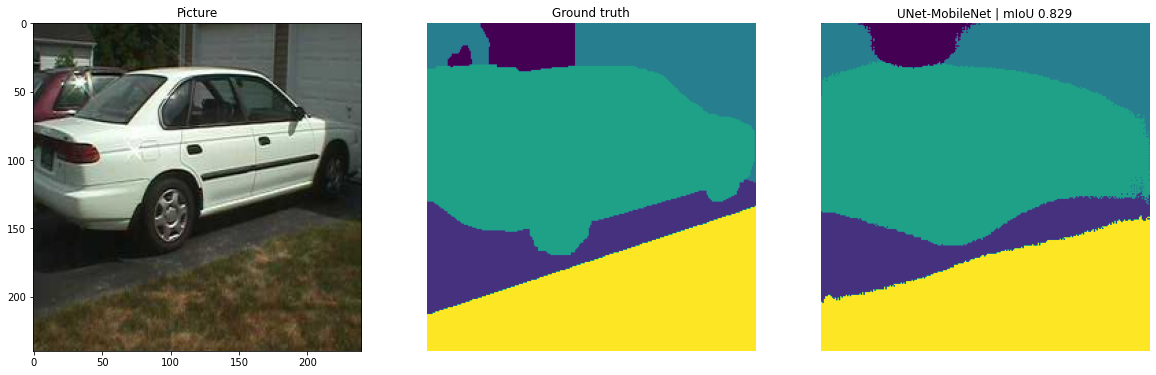

In [135]:
#Визуализируем картинку, маску, и предикшн
image, mask, img = test_set[16]
def predict_image_mask_miou(model, image, mask, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    model.eval()
    image = image.view(-1, 3, 240, 240)
    model.to(device); image=image.to(device)
    mask = mask.to(device)
    with torch.no_grad():
        
        output = model(image)
        score = mIoU(output, mask)
        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)
    return masked, score

pred_mask, score = predict_image_mask_miou(model, image, mask)

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
ax1.imshow(img.numpy().transpose(1, 2, 0))
ax1.set_title('Picture');

ax2.imshow(mask)
ax2.set_title('Ground truth')
ax2.set_axis_off()

ax3.imshow(pred_mask)
ax3.set_title('My own DeConvNet | mIoU {:.3f}'.format(score))
ax3.set_axis_off()

In [ ]:
#можно также делать разные варианты, например deconv + dilated + multi-scale (или что-то другое, например max unpool + skip connections)


In [16]:
#Теперь реализуем уже готовую архитектуру UNet (c backbone: mobilenet_v2, но есть другие)
model = smp.Unet('mobilenet_v2', encoder_weights='imagenet', classes=9, activation=None, encoder_depth=5, decoder_channels=[256, 128, 64, 32, 16])

In [17]:
#обучаем
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.8)
num_epochs = 50

best_model_wts = model.state_dict()
best_acc = 0.0
    

losses = {'train': [], "val": []}

# Run the training loop for defined number of epochs
for epoch in range(num_epochs):
    running_loss = 0
    processed_data = 0
    processed_size1 = 0
    running_loss1 = 0
    running_corrects = 0
    val_iou_score = 0
    test_accuracy = 0
    for batch_i, (data, target) in tqdm(enumerate(trainloader), total = len(trainloader)):
        data, target = data.to(device), target.to(device)
        model.train()
        optimizer.zero_grad()
        y_pred = model(data)
        loss = criterion(y_pred, target)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * data.size(0)
        processed_data += data.size(0)
    train_loss = running_loss / processed_data
    model.eval()
    with torch.no_grad():
        for data, target in tqdm(valloader):
            data, target = data.to(device), target.to(device)
            probs = model(data)
            lossfc = criterion(probs, target) 
            running_loss1 += lossfc.item() * data.size(0)
            processed_size1 += data.size(0)
            val_iou_score +=  mIoU(probs, target)
            test_accuracy += pixel_accuracy(probs, target)
        
            
        val_loss = running_loss1 / processed_size1 
        val_acc = test_accuracy / processed_size1
        val_iou = val_iou_score / processed_size1
        
        losses["train"].append(train_loss)
        losses["val"].append(val_loss)
        
        if val_acc > best_acc:
                best_acc = val_acc
                best_model_wts = model.state_dict()
    print("Epoch" + " " + str(epoch) + ":", "train_loss:" + str(train_loss), "val_loss:" + str(val_loss), "val_acc:" + str(val_acc), "val_IoU:" + str(val_iou))
    scheduler.step()

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 0: train_loss:1.5135543829017033 val_loss:1.1858754341418927 val_acc:0.07405184232271635 val_IoU:0.04247698561902034


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 1: train_loss:1.0396339373605061 val_loss:0.8586849386875446 val_acc:0.0841313993013822 val_IoU:0.0540751608786198


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 2: train_loss:0.8609795869427981 val_loss:0.7339565112040594 val_acc:0.08579775296724759 val_IoU:0.05590519681120261


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 3: train_loss:0.8086637701955222 val_loss:0.6477783918380737 val_acc:0.08867333045372598 val_IoU:0.05800676987772949


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 4: train_loss:0.7345396246258363 val_loss:0.6420524876851302 val_acc:0.08900794396033654 val_IoU:0.05995775137764095


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 5: train_loss:0.7063140822735625 val_loss:0.5520272667591388 val_acc:0.09089280348557693 val_IoU:0.060470137787257114


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 6: train_loss:0.6408465035440187 val_loss:0.49023277025956374 val_acc:0.09194619985727163 val_IoU:0.06234767465941122


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 7: train_loss:0.6384472397371972 val_loss:0.5022933253875146 val_acc:0.09102447509765625 val_IoU:0.06003921147676236


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 8: train_loss:0.6224799754297857 val_loss:0.4757753358437465 val_acc:0.0924798349233774 val_IoU:0.06194638889880869


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 9: train_loss:0.6028627631573529 val_loss:0.5060608157744775 val_acc:0.0916583251953125 val_IoU:0.06184158245313181


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 10: train_loss:0.5676544368473304 val_loss:0.4348823909576123 val_acc:0.09381624661959134 val_IoU:0.06606721374516333


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 11: train_loss:0.5726043230315806 val_loss:0.393466965510295 val_acc:0.09439300537109375 val_IoU:0.06648644919139048


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 12: train_loss:0.5174673672984628 val_loss:0.3805826764840346 val_acc:0.0945208974984976 val_IoU:0.06832395378540866


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 13: train_loss:0.5013491874335134 val_loss:0.3609304428100586 val_acc:0.09467130220853366 val_IoU:0.06618742817195418


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 14: train_loss:0.48773248901004196 val_loss:0.3954863456579355 val_acc:0.09424830510066107 val_IoU:0.06970010038609864


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 15: train_loss:0.47971596220785356 val_loss:0.3362005582222572 val_acc:0.09604417067307694 val_IoU:0.06918620905501079


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 16: train_loss:0.4849363745908836 val_loss:0.34510910511016846 val_acc:0.09524198091947114 val_IoU:0.06714186746178687


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 17: train_loss:0.46667597079359535 val_loss:0.31720519065856934 val_acc:0.09668339655949519 val_IoU:0.06956326854719858


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 18: train_loss:0.4449275480422182 val_loss:0.29769659959352934 val_acc:0.09682574932391827 val_IoU:0.07119642109346462


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 19: train_loss:0.4366367627386403 val_loss:0.29799118408790004 val_acc:0.098001708984375 val_IoU:0.07339975459624307


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 20: train_loss:0.451804003088532 val_loss:0.29231149760576397 val_acc:0.09823559100811298 val_IoU:0.07442405215066682


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 21: train_loss:0.4276099911404316 val_loss:0.2815787127384773 val_acc:0.09837059607872595 val_IoU:0.07344811538494679


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 22: train_loss:0.43083149828919076 val_loss:0.28294949806653535 val_acc:0.09824732853816105 val_IoU:0.07401756653456086


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 23: train_loss:0.4066267214638139 val_loss:0.2737163305282593 val_acc:0.09897864708533655 val_IoU:0.07766879555727091


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 24: train_loss:0.3968369775164911 val_loss:0.2659493317970863 val_acc:0.09891500619741588 val_IoU:0.0763313586304481


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 25: train_loss:0.40136523116831135 val_loss:0.24346804848084083 val_acc:0.09934469369741586 val_IoU:0.07627864103839126


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 26: train_loss:0.40932572321083305 val_loss:0.2741238795793973 val_acc:0.09825660118689905 val_IoU:0.0755038572965623


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 27: train_loss:0.38351935643225804 val_loss:0.23276654344338638 val_acc:0.10007321871243989 val_IoU:0.08182745799731661


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 28: train_loss:0.39824150064412284 val_loss:0.25820552615018993 val_acc:0.09870276817908655 val_IoU:0.07659800885891042


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 29: train_loss:0.3978825057872851 val_loss:0.25856588093134075 val_acc:0.09904738206129808 val_IoU:0.07641895449337571


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 30: train_loss:0.3778833645850317 val_loss:0.2321357291478377 val_acc:0.09974022498497595 val_IoU:0.07796258420551236


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 31: train_loss:0.368368851891026 val_loss:0.23758921714929435 val_acc:0.09979726938100962 val_IoU:0.07877783741800767


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 32: train_loss:0.3424680038100708 val_loss:0.2159026826803501 val_acc:0.10060685377854567 val_IoU:0.07848811026475411


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 33: train_loss:0.3360400134407525 val_loss:0.2016313488666828 val_acc:0.10069889948918269 val_IoU:0.0812810946359193


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 34: train_loss:0.3340664239903222 val_loss:0.20906166159189665 val_acc:0.10066075251652645 val_IoU:0.08066581932692736


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 35: train_loss:0.3515861115859867 val_loss:0.19969099989304176 val_acc:0.10080770639272837 val_IoU:0.08184004946454924


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 36: train_loss:0.3252207054708243 val_loss:0.1950069528359633 val_acc:0.1009692617563101 val_IoU:0.0809375235838673


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 37: train_loss:0.3319421893688222 val_loss:0.19792462770755476 val_acc:0.10062338022085336 val_IoU:0.08001283356694855


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 38: train_loss:0.33837416536049036 val_loss:0.1982144805101248 val_acc:0.10066650390625 val_IoU:0.08148594247376782


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 39: train_loss:0.333811555612046 val_loss:0.20761282512774834 val_acc:0.10060377854567308 val_IoU:0.08142052796856061


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 40: train_loss:0.3119984580571264 val_loss:0.184842871931883 val_acc:0.10095196063701924 val_IoU:0.08198721875674882


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 41: train_loss:0.2974500252920039 val_loss:0.18295357548273528 val_acc:0.10133756197415865 val_IoU:0.08291936433301464


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 42: train_loss:0.3034357507954832 val_loss:0.1827969803259923 val_acc:0.10136174128605768 val_IoU:0.0825176615564642


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 43: train_loss:0.3105758443526331 val_loss:0.18217114531076872 val_acc:0.10120694673978366 val_IoU:0.08306338183287122


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 44: train_loss:0.3095248230703974 val_loss:0.18219530009306395 val_acc:0.10138441819411058 val_IoU:0.08280417012066184


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 45: train_loss:0.28345873570359703 val_loss:0.16384832904889032 val_acc:0.10170903132512019 val_IoU:0.08367943351198724


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 46: train_loss:0.2861521925686965 val_loss:0.1683282726086103 val_acc:0.10161468505859374 val_IoU:0.08346384220206739


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 47: train_loss:0.287663554186227 val_loss:0.16689445880743173 val_acc:0.10183173546424278 val_IoU:0.08246410960526018


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 48: train_loss:0.2826858479465168 val_loss:0.16553278611256525 val_acc:0.10176823542668269 val_IoU:0.08240136614223649


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 49: train_loss:0.2874400009333469 val_loss:0.17428127160439125 val_acc:0.1014361572265625 val_IoU:0.08427725149144807


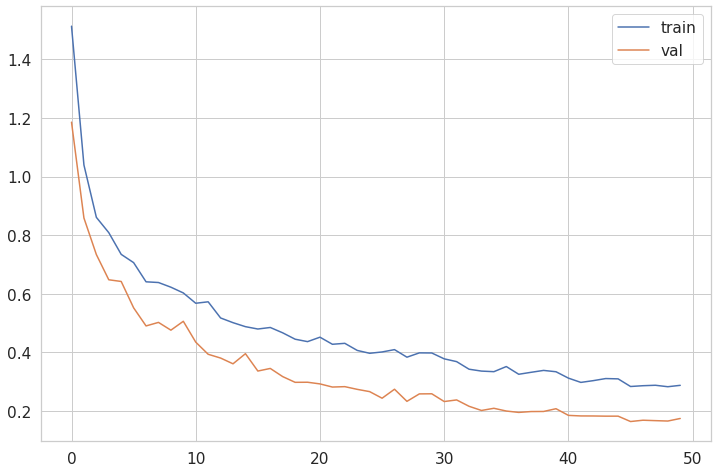

In [20]:
#Выведем график лосса
#Как видим обучается UNet с pretrained encoder'ом гораздо быстрее собственной модели, и за 50 эпох достигла качества в 2 раза лучше чем собственная за 260
#Если добавить больше эпох, может получиться очень хороший результат
sns.set(style="whitegrid", font_scale=1.4)
plt.figure(figsize=(12, 8))
plt.plot(losses['train'], label="train")
plt.plot(losses['val'], label="val")
plt.legend()
plt.show()

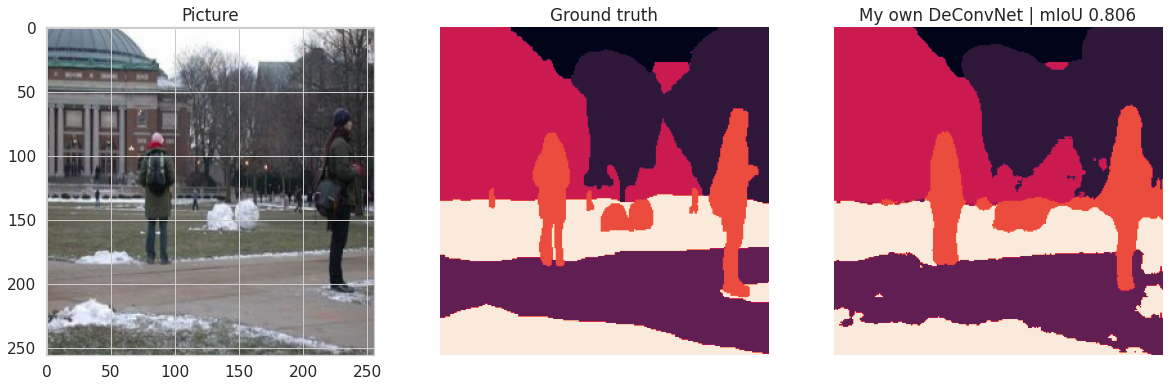

In [28]:
#Посмотрим на результат - выглядит лучше чем собственная.
image, mask, img = test_set[8]
def predict_image_mask_miou(model, image, mask, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    model.eval()
    image = image.view(-1, 3, 256, 256)
    model.to(device); image=image.to(device)
    mask = mask.to(device)
    with torch.no_grad():
        
        output = model(image)
        score = mIoU(output, mask)
        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)
    return masked, score

pred_mask, score = predict_image_mask_miou(model, image, mask)

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
ax1.imshow(img.numpy().transpose(1, 2, 0))
ax1.set_title('Picture');

ax2.imshow(mask)
ax2.set_title('Ground truth')
ax2.set_axis_off()

ax3.imshow(pred_mask)
ax3.set_title('My own DeConvNet | mIoU {:.3f}'.format(score))
ax3.set_axis_off()